### RNN with TensorFlow API

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

### The Data

In [2]:
class TimeSeriesData():
    
    def __init__(self, num_points, xmin, xmax):
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax - xmin) / num_points
        self.x_data = np.linspace(xmin, xmax, num_points)
        self.y_true = np.sin(self.x_data)
        
    def return_true(self, x_series):
        return np.sin(x_series)
    
    def next_batch(self, batch_size, steps, return_batch_st=False):
        
        # Grab a random starting pont for each batch
        rand_start = np.random.rand(batch_size, 1)
        
        # Convert to be on time series
        ts_start = rand_start * (self.xmax - self.xmin - (steps * self.resolution))
        
        # Create batch time series on t exis
        batch_ts = ts_start + np.arange(0.0, steps + 1) * self.resolution
        
        # Create Y data for time series in the batch
        y_batch = np.sin(batch_ts)
        
        # Format for RNN
        if return_batch_st:
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1), batch_ts
        else:
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1)

In [3]:
ts_data = TimeSeriesData(250, 0, 10)

In [4]:
ts_data.x_data

array([ 0.        ,  0.04016064,  0.08032129,  0.12048193,  0.16064257,
        0.20080321,  0.24096386,  0.2811245 ,  0.32128514,  0.36144578,
        0.40160643,  0.44176707,  0.48192771,  0.52208835,  0.562249  ,
        0.60240964,  0.64257028,  0.68273092,  0.72289157,  0.76305221,
        0.80321285,  0.84337349,  0.88353414,  0.92369478,  0.96385542,
        1.00401606,  1.04417671,  1.08433735,  1.12449799,  1.16465863,
        1.20481928,  1.24497992,  1.28514056,  1.3253012 ,  1.36546185,
        1.40562249,  1.44578313,  1.48594378,  1.52610442,  1.56626506,
        1.6064257 ,  1.64658635,  1.68674699,  1.72690763,  1.76706827,
        1.80722892,  1.84738956,  1.8875502 ,  1.92771084,  1.96787149,
        2.00803213,  2.04819277,  2.08835341,  2.12851406,  2.1686747 ,
        2.20883534,  2.24899598,  2.28915663,  2.32931727,  2.36947791,
        2.40963855,  2.4497992 ,  2.48995984,  2.53012048,  2.57028112,
        2.61044177,  2.65060241,  2.69076305,  2.73092369,  2.77

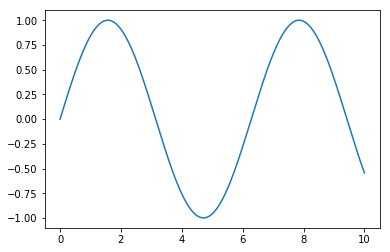

In [5]:
plt.plot(ts_data.x_data, ts_data.y_true)

In [6]:
# num of steps in batch
num_time_steps = 30

In [7]:
y1, y2, ts = ts_data.next_batch(1, num_time_steps, True)

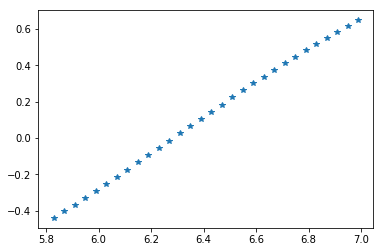

In [8]:
plt.plot(ts.flatten()[1:], y2.flatten(),'*')

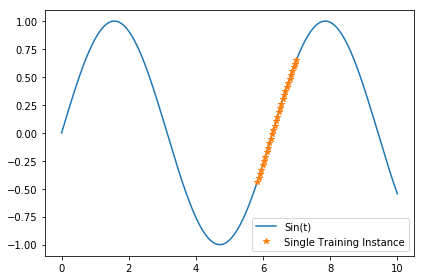

In [9]:
plt.plot(ts_data.x_data,ts_data.y_true,label='Sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*',label='Single Training Instance')
plt.legend()
plt.tight_layout()

### Training Instance and what to predict
We are trying to predict a time series shifted over by t+1

In [10]:
train_inst = np.linspace(5, 5 + ts_data.resolution * (num_time_steps + 1), num_time_steps + 1)

In [11]:
train_inst

array([5.        , 5.04133333, 5.08266667, 5.124     , 5.16533333,
       5.20666667, 5.248     , 5.28933333, 5.33066667, 5.372     ,
       5.41333333, 5.45466667, 5.496     , 5.53733333, 5.57866667,
       5.62      , 5.66133333, 5.70266667, 5.744     , 5.78533333,
       5.82666667, 5.868     , 5.90933333, 5.95066667, 5.992     ,
       6.03333333, 6.07466667, 6.116     , 6.15733333, 6.19866667,
       6.24      ])

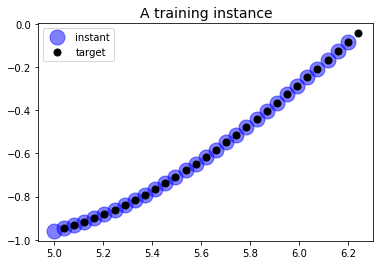

In [12]:
plt.title("A training instance", fontsize=14)
plt.plot(train_inst[:-1],ts_data.return_true(train_inst[:-1]),'bo', markersize=15, alpha=0.5, label="instant");
plt.plot(train_inst[1:], ts_data.return_true(train_inst[1:]), 'ko', markersize=7, label="target");
plt.legend()

### Create the Model

In [13]:
tf.reset_default_graph()

In [14]:
num_inputs = 1

In [15]:
num_neurons = 100

In [16]:
num_outputs = 1

In [17]:
learning_rate = 0.0001

In [18]:
num_train_iterations = 2000

In [19]:
batch_size = 1

#### Placeholders

In [20]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])

In [21]:
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

#### RNN Cell Layer

In [22]:
rnn_cell = tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu)
cell = tf.contrib.rnn.OutputProjectionWrapper(rnn_cell, output_size=num_outputs)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [23]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.


### Loss Function

In [24]:
loss = tf.reduce_mean(tf.square(outputs - y))

### Optimizer

In [25]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [26]:
train = optimizer.minimize(loss)

### Init Variables

In [27]:
init = tf.global_variables_initializer()

### Create Session

In [28]:
saver = tf.train.Saver()

In [29]:
with tf.Session() as sess:
    sess.run(init)
    
    for iter in range(num_train_iterations):
        X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        sess.run(train, feed_dict={X:X_batch,y:y_batch})
        
        if iter % 100== 0:
            mse = loss.eval(feed_dict={X:X_batch, y:y_batch})
            print(iter, "\tsMSE", mse)
            
    saver.save(sess, '../../models/rnn_time_series_model_codealong')

0 	sMSE 0.23169997
100 	sMSE 0.15051332
200 	sMSE 0.006808179
300 	sMSE 0.029137898
400 	sMSE 0.0050747376
500 	sMSE 0.0023537127
600 	sMSE 0.008747576
700 	sMSE 0.007321998
800 	sMSE 0.014658688
900 	sMSE 0.00045757627
1000 	sMSE 0.0033529557
1100 	sMSE 0.0060891444
1200 	sMSE 0.0038032073
1300 	sMSE 0.0066272873
1400 	sMSE 0.0034305416
1500 	sMSE 0.008069322
1600 	sMSE 0.0024196017
1700 	sMSE 0.0018033608
1800 	sMSE 0.002114067
1900 	sMSE 0.00023458542


### Predict a time series t+1

In [32]:
with tf.Session() as sess:
    saver.restore(sess, '../../models/rnn_time_series_model_codealong')
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    y_pred = sess.run(outputs, feed_dict={X:X_new})

INFO:tensorflow:Restoring parameters from ../../models/rnn_time_series_model_codealong


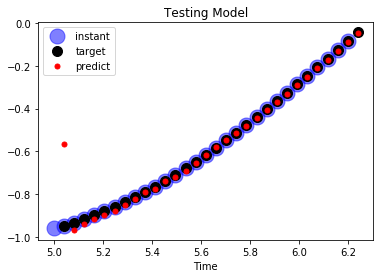

In [35]:
plt.title("Testing Model")

# Training instance
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), 'bo', markersize=15, alpha=0.5,label="instant")

# Target prediction
plt.plot(train_inst[1:], np.sin(train_inst[1:]), 'ko', markersize=10,label="target")

# Model prediction
plt.plot(train_inst[1:], y_pred[0,:,0], 'r.', markersize=10,label="predict")

plt.xlabel("Time")
plt.legend()


### Generating New Sequence

In [36]:
with tf.Session() as sess:
    
    saver.restore(sess, '../../models/rnn_time_series_model_codealong')
    
    # Seed zeros
    zero_seq_seed = [0 for i in range(num_time_steps)]
    for iter in range(len(ts_data.x_data) - num_time_steps):
        X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X:X_batch})
        zero_seq_seed.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ../../models/rnn_time_series_model_codealong


Text(0, 0.5, 'Value')

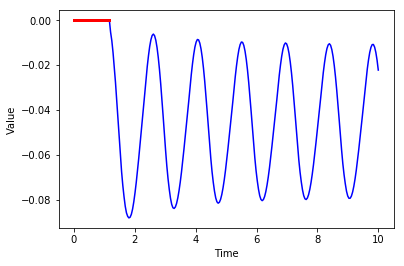

In [37]:
plt.plot(ts_data.x_data, zero_seq_seed, "b-")
plt.plot(ts_data.x_data[:num_time_steps], zero_seq_seed[:num_time_steps], "r", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

In [38]:
with tf.Session() as sess:
    
    saver.restore(sess, '../../models/rnn_time_series_model_codealong')
    
    # Seed zeros
    train_instance = list(ts_data.y_true[:30])
    for iter in range(len(train_instance) - num_time_steps):
        X_batch = np.array(train_instance[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X:X_batch})
        train_instance.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ../../models/rnn_time_series_model_codealong


Text(0, 0.5, 'Value')

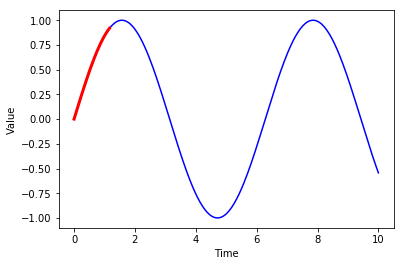

In [39]:
plt.plot(ts_data.x_data, ts_data.y_true, "b-")
plt.plot(ts_data.x_data[:num_time_steps], train_instance[:num_time_steps], "r", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")